## Learning from Kaggle Notebook

### Using tensorflow for image recognition

In [ ]:
pip install pydicom

In [ ]:
!pip install -q ../input/for-pydicom/pylibjpeg-1.4.0-py3-none-any.whl
!pip install -q ../input/for-pydicom/python_gdcm-3.0.14-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
!pip install -q ../input/for-pydicom/pylibjpeg_libjpeg-1.3.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl

In [ ]:
pip install pylibjpeg pylibjpeg-libjpeg pydicom

In [1]:
import os 
import pathlib
import glob 
from tqdm import tqdm 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pydicom
from pydicom import dcmread
import pylibjpeg
import tensorflow as tf

/home/ec2-user/anaconda3/envs/tensorflow2_p38/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import boto3

s3 = boto3.resource('s3')
bucket_name = 'evan-callaghan-bucket'
bucket = s3.Bucket(bucket_name)

file_key = 'Kaggle-Spine-Fracture-Detection/train.csv'
file_key2 = 'Kaggle-Spine-Fracture-Detection/train_bounding_boxes.csv'

bucket_object = bucket.Object(file_key)
bucket_object2 = bucket.Object(file_key2)

file_object = bucket_object.get()
file_object2 = bucket_object2.get()

file_content_stream = file_object.get('Body')
file_content_stream2 = file_object2.get('Body')

## Reading the data
train = pd.read_csv(file_content_stream)
train_boxes = pd.read_csv(file_content_stream2)

In [3]:
sns.set()

## Defining parameters
EPOCHS = 10
BATCH_SIZE = 16
IMAGE_SIZE = (512, 512)
SEED = 42

## Setting seed
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Loading the DICOM files properly

In [4]:
## Subsetting the train data-frame
train = train[np.isin(train['StudyInstanceUID'], ['1.2.826.0.1.3680043.10606', '1.2.826.0.1.3680043.10815', 
                                                  '1.2.826.0.1.3680043.12121'])].reset_index(drop = True)

In [5]:
## Defining an empty list to store all images
img_list = []

## Looping through all study instances in example
for instance in train['StudyInstanceUID'].unique():
    
    ## Getting all images for the particular instance
    img_to_append = glob.glob(f'Sample_Images/{instance}/*.dcm')
    
    ## Appending all images to img_list
    img_list.extend(img_to_append)
    
## Printing the length of the list
print(len(img_list))

30


In [6]:
def load_dicom(path):
    """
    reads a dicom file and loads the image array inside it
    inputs:
        path - the path of the required dicom file
    returns:
        data - image pixel arrays
    """
    img = pydicom.dcmread(path)
    data = img.pixel_array
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data

In [7]:
def data_generator():
    """
    a function that will load the dataset from a list of image paths
    """
    for path in img_list:
        data = load_dicom(path)
        yield data  # return the data has generator

In [8]:
## Defining a tensorflow dataset variable that will use the generator to load the image data
train_dataset = tf.data.Dataset.from_generator(data_generator, (tf.uint8))

## Looking of the dataset contents
for i in train_dataset.take(1):
    print(i.shape)
    print(type(i))

(512, 512)
<class 'tensorflow.python.framework.ops.EagerTensor'>


2022-08-20 16:02:06.493533: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-08-20 16:02:06.493605: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-16-83-243.ca-central-1.compute.internal): /proc/driver/nvidia/version does not exist
2022-08-20 16:02:06.495802: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


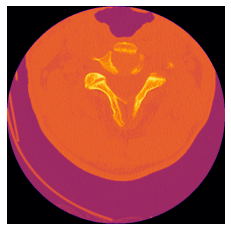

In [9]:
def show_single(img, cmap="inferno"):
    """
    plots a single image
    """
    plt.imshow(img, cmap=cmap)
    plt.axis("off")
    
show_single(i)

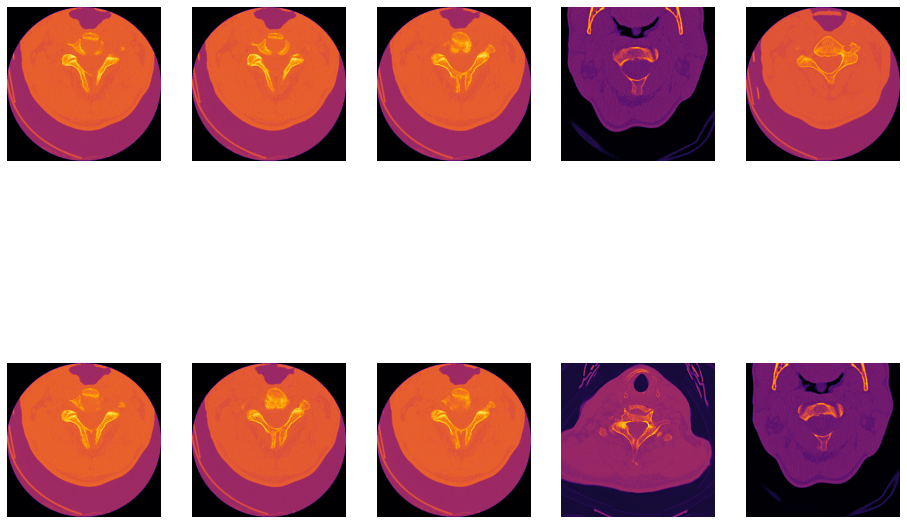

In [10]:
def show_batch(cmap="inferno"):
    """
    visualizes a batch of images
    """
    plt.figure(figsize=(16, 12))
    for i, img in enumerate(train_dataset.take(10)):  # iterate through the dataset
        plt.subplot(2, 5, i+1)
        show_single(img, cmap=cmap)
    plt.show()
    
show_batch()

## Generating data from the DICOM files to be used for modeling

In [11]:
def data_generator():
    
    ## Looping through all unique StudyInstanceUID values
    for i, study_instance in enumerate(train['StudyInstanceUID'].unique()):
        
        ## Loopig through all images in the associated instance folder
        for dcm in os.listdir(f'Sample_Images/{study_instance}'):
            
            ## Defining an empty list to eventually store train labels
            train_labels = []
            
            ## Defining the image path
            path = f'Sample_Images/{study_instance}/{dcm}'
            
            ## Loading image from path
            img = load_dicom(path)
            
            ## Resizing each image into a shape of (512, 512) and then normalizing
            img = np.resize(img, (512, 512))
            img = img / 255.0
            
            ## Converting from gray scale to rgb
            img = tf.expand_dims(img, axis=-1)
            img = tf.image.grayscale_to_rgb(img)
            
            ## Appending train labels to each image
            train_labels.extend([
                train.loc[i, "C1"],
                train.loc[i, "C2"],
                train.loc[i, "C3"],
                train.loc[i, "C4"],
                train.loc[i, "C5"],
                train.loc[i, "C6"],
                train.loc[i, "C7"],
                train.loc[i, "patient_overall"]])
            
            ## Yielding the image and associated labels
            yield img, train_labels

In [12]:
train_data = tf.data.Dataset.from_generator(data_generator, (tf.float32, tf.int8))

In [13]:
for img, label in train_data.take(1):
    print(img.shape)
    print(label.shape)
    print(label)

(512, 512, 3)
(8,)
tf.Tensor([0 0 0 0 0 0 1 1], shape=(8,), dtype=int8)


## Modeling

In [14]:
## Counting the number of total images
img_count = 0
for _, _ in enumerate(train['StudyInstanceUID'].unique()):
    for _ in os.listdir(f'Sample_Images/{_}'):
        img_count += 1
print(img_count)

30


In [15]:
## Splitting the data into train and validation sets
val_size = int(img_count * 0.2)
train_data = train_data.skip(val_size)
val_data = train_data.take(val_size)

In [16]:
def configure_for_performance(data):
    data = data.cache()
    data = data.batch(16)
    data = data.prefetch(buffer_size=tf.data.AUTOTUNE)
    return data

In [17]:
train_data = configure_for_performance(train_data)
val_data = configure_for_performance(val_data)

In [18]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dense, Dropout, Flatten

In [19]:
# Defining Alex Net model

def alex_net():
    model = Sequential()

    # 1st Convolutional Layer
    model.add(Conv2D(filters=96, input_shape=(512,512,3), kernel_size=(11,11),\
     strides=(4,4), padding='valid', activation="relu"))
    # Pooling 
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Batch Normalisation before passing it to the next layer
    model.add(BatchNormalization())

    # 2nd Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid', activation="relu"))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # 3rd Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid', activation="relu"))
    # Batch Normalisation
    model.add(BatchNormalization())

    # 4th Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid', activation="relu"))
    # Batch Normalisation
    model.add(BatchNormalization())

    # 5th Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid', activation="relu"))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # Passing it to a dense layer
    model.add(Flatten())
    # 1st Dense Layer
    model.add(Dense(4096, input_shape=(512*512*3,), activation="relu"))
    # Add Dropout to prevent overfitting
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # 2nd Dense Layer
    model.add(Dense(4096, activation="relu"))
    # Add Dropout
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # 3rd Dense Layer
    model.add(Dense(1000, activation="relu"))
    # Add Dropout
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # Output Layer with 8 probability classes
    model.add(Dense(8, activation="softmax"))
    return model

In [ ]:
## Calling the Alex Net model
model = alex_net()

## Printing model results
model.summary()

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()]
             )

In [ ]:
# training
history = model.fit(train_data, validation_data=val_data,
                   epochs=EPOCHS)

In [ ]:
# visualize training 
def viz_loss(history):
    train_loss = history["loss"]
    val_loss = history["val_loss"]
    iters = [i for i in range(EPOCHS)]
    
    plt.plot(iters, train_loss, label="Training Loss")
    plt.plot(iters, val_loss, label="Validation Loss")
    plt.title("A plot of Loss against number of iterations")
    plt.legend()
    plt.show()
    
def viz_acc(history):
    train_loss = history["categorical_accuracy"]
    val_loss = history["val_categorical_accuracy"]
    iters = [i for i in range(EPOCHS)]
    
    plt.plot(iters, train_loss, label="Training Accuracy")
    plt.plot(iters, val_loss, label="Validation Accuracy")
    plt.title("A plot of Accuracy against number of iterations")
    plt.legend()
    plt.show()
    
viz_loss(history.history)
viz_acc(history.history)